**План работы**

1. Загрузка данных
 - подключенни к базе данных
 - загрузка таблиц
 - получение общей информации о таблицах
 - соединение всех таблиц в один датафрейм
2. Проведение исследовательского анализа данных
 - 2.1 Анализ данных на пропущенные значения
 - 2.2 Сравнение распределения величины ежемесячных платежей всех действующих клиентов и тех, кто ушел. Для каждой группы сделать расчет статистических показателей: среднее, минимальное и максимальное значение, медиана, величины 25%, 75% квартилей. Построение гистограмм распределения.
 - 2.3 Сравнение поведения двух групп клиентов. Для каждой группы построение гистограмм отражающих:
    - долю пользователей телефонной связи
    - долю интернет пользователей
    - долю пользования интернет-услугами и способом подключения к интернету
    - долю пользователей по показателям персональных данных
    - долю пользователей по типу контракта
    - долю пользователей по способу оплаты
3. Обучение моделей
 - анализ на наличие выбросов в количественных признаках
 - создание целевого признака и дополнительных признаков
 - анализ на пропущенные значения и дальнейшее из заполнение
 - масштабирование количественных признаков
 - кодирование категориальных признаков
     - 3.1 Решающее дерево
     - 3.2 CatBoost
     - 3.3 Полносвязная нейронная сеть
4. Тестирование модели
 - проведение графического анализа "Матрица ошибок". Вывести полноту и точность на график
 - анализ важности основных факторов, влияющих на отток клиентов
 - для одного из выявленных важных факторов провести дополнительное исследование:
        - показать график зависимости фактора и целевой переменной
5. Общий вывод по работе

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sqlalchemy import create_engine

from tqdm import notebook

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score


from catboost import CatBoostRegressor, Pool, metrics



from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix



from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression



from catboost import CatBoostClassifier, Pool, metrics


import torch
import torch.nn as nn

from math import sqrt
from math import ceil
import random
from sklearn.metrics import mean_squared_error

import phik
from phik.report import plot_correlation_matrix
from phik import report



import warnings
warnings.filterwarnings('ignore')

## Шаг 1. Загрузите данные
Подключитесь к базе данных:

In [ ]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-final' # название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)
engine = create_engine(connection_string)

Создадим функцию, которая будет загружать таблицы из SQL и создавать датафреймы

In [ ]:
def read_data_sql(df, table):
    query = '''
    SELECT *
    FROM '''+ table
    df = pd.read_sql_query(query, con = engine)
    return df

Загрузим наши таблицы с данными в датафреймы `contract`, `personal`, `internet`, `phone`

In [ ]:
contract, personal, internet, phone = [pd.DataFrame()]*4
contract = read_data_sql(contract, 'telecom.contract')
personal = read_data_sql(personal, 'telecom.personal')
internet = read_data_sql(internet, 'telecom.internet')
phone = read_data_sql(phone, 'telecom.phone')
for i in [contract, personal, internet, phone]:
    display(i.head(2))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No


,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No


,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No


Датафреймы `phone` и `internet` в нулевой строке содержат названия столбцов. Напишем функцию, которая переименует столбцы взяв значения и нулевой строки.

In [ ]:
def rename_columns(df):
    df = df.rename(columns = df.loc[0]).drop(index=0).reset_index(drop=True)
    return df

Применим нашу функцию

In [ ]:
phone = rename_columns(phone)
internet = rename_columns(internet)

Создадим функцию, которая будет выдавать общую информацию о наших датафреймах.

In [ ]:
def df_get_info(df, name):
    df.name = name
    display(df.head())
    print('Общая информация о датафрейме', df.name, end='\n\n\n')
    print(df.info(), end='\n\n\n')
    print('Количество пропущенных значений в датафрейме', df.name, end='\n\n\n')
    print(df.isna().sum())
    print('Количество дублированных строк в датафрейме', df.name, end='\n\n\n')
    print(df.duplicated().sum(), end='\n\n\n')
    print('Статистическая информация о датафрейме', df.name, end='\n\n\n')
    display(df.describe())
    print('\n\n\n')


In [ ]:
lisf_df  = [contract, internet, personal, phone]
list_df_name = ['contract', 'internet', 'personal', 'phone']

In [ ]:
for df_, name_ in zip(lisf_df, list_df_name):
    df_get_info(df_, name_)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


Общая информация о датафрейме contract


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB
None


Количество пропущенных значений в датафрейме contract


customerID             0
BeginDate              0
EndDate             5174
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
dtype: int64
Количество дублированных строк в датафрейме contract


,MonthlyCharges,TotalCharges
count,7043.000000,7032.000000
mean,64.761692,2283.300441
std,30.090047,2266.771362
min,18.250000,18.800000
25%,35.500000,401.450000
50%,70.350000,1397.475000
75%,89.850000,3794.737500
max,118.750000,8684.800000


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Общая информация о датафрейме internet


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None


Количество пропущенных значений в датафрейме internet


customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64
Количество дублированных строк в датафрейме internet


0


Статистическая информация о датафрейме i

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Общая информация о датафрейме personal


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


Количество пропущенных значений в датафрейме personal


customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64
Количество дублированных строк в датафрейме personal


0


Статистическая информация о датафрейме personal




,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Общая информация о датафрейме phone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


Количество пропущенных значений в датафрейме phone


customerID       0
MultipleLines    0
dtype: int64
Количество дублированных строк в датафрейме phone


0


Статистическая информация о датафрейме phone




,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


**В датафрейме `contract` столбцы `BeginDate`и `EndDate` имееют тип `object`, хотя содержат данные о дате. Потребуется изменения типа данных для этих столбцов.**



**Столбец `EndDate` содержит 5174 незаполненных значений, то есть это те клиенты, которые пользуются услугами данного оператора до сих пор. Если же в колонке имеется значение, то оно указывает на дату, когда клиент перестал пользоваться услугами данной компании. В дальнейшем будем использовать значение этой колонки в качестве целевой переменной (клиент ушел/не ушел)**

**Столбец `TotalCharges` содержит 11 значений `Nan`**


In [ ]:
contract.loc[contract['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,NaN
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,NaN
9,3213-VVOLG,2020-02-01,None,Two year,No,Mailed check,25.35,NaN
10,2923-ARZLG,2020-02-01,None,One year,Yes,Mailed check,19.70,NaN
11,2775-SEFEE,2020-02-01,None,Two year,Yes,Bank transfer (automatic),61.90,NaN
4408,7644-OMVMY,2020-02-01,None,Two year,No,Mailed check,19.85,NaN
5160,2520-SGTTA,2020-02-01,None,Two year,No,Mailed check,20.00,NaN


Как видно, что все `Nan` принадлежат новым клиентам, которые пришли 2020-02-01. База данных актуальна тоже на эту дату. Следовательно можно заполнить пропущенные значения из столбца `MonthlyCharges`

In [ ]:
index_total_charges = contract.loc[contract['TotalCharges'].isna()].index
contract.loc[contract['TotalCharges'].isna(), 'TotalCharges'] = contract['MonthlyCharges']

Проверка заполнения

In [ ]:
contract.loc[index_total_charges]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,52.55
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,20.25
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,80.85
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,25.75
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,56.05
9,3213-VVOLG,2020-02-01,None,Two year,No,Mailed check,25.35,25.35
10,2923-ARZLG,2020-02-01,None,One year,Yes,Mailed check,19.70,19.70
11,2775-SEFEE,2020-02-01,None,Two year,Yes,Bank transfer (automatic),61.90,61.90
4408,7644-OMVMY,2020-02-01,None,Two year,No,Mailed check,19.85,19.85
5160,2520-SGTTA,2020-02-01,None,Two year,No,Mailed check,20.00,20.00


Функция `cast_str_date` будет менять тип данных с `object` на `datetime`

In [ ]:
def cast_str_date(df, list_columns):
    for column in list_columns:
        df[column] = pd.to_datetime(df[column], format='%Y-%m-%d')

Применим нашу функцию к столбцам `BeginDate`, `EndDate`

In [ ]:
cast_str_date(contract, ['BeginDate', 'EndDate'])
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


Для удобства соединим все наши таблицы в один датафрейм `df` по столбцу `customerID`

In [ ]:
df = contract.merge(internet, how='left',  left_on='customerID', right_on='customerID')
for df_ in [personal, phone]:
    df = df.merge(df_, how='left',  left_on='customerID', right_on='customerID')
df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,52.55,DSL,Yes,No,Yes,Yes,Yes,No,Female,0,Yes,Yes,NaN
1,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,20.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,No,Yes,No
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,80.85,DSL,Yes,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,No
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,NaT,Two year,Yes,Bank transfer (automatic),21.15,1419.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,0,No,No,No
7039,6840-RESVB,2019-02-26,NaT,One year,Yes,Mailed check,84.80,1990.50,DSL,Yes,No,Yes,Yes,Yes,Yes,Male,0,Yes,Yes,Yes
7040,2234-XADUH,2019-09-02,NaT,One year,Yes,Credit card (automatic),103.20,7362.90,Fiber optic,No,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,Yes
7041,4801-JZAZL,2019-06-26,NaT,Month-to-month,Yes,Electronic check,29.60,346.45,DSL,Yes,No,No,No,No,No,Female,0,Yes,Yes,NaN


**Вывод**


**В датафрейме `contract` столбцы `BeginDate`и `EndDate` имееют тип `object`, хотя содержат данные о дате. Потребуется изменения типа данных для этих столбцов.**



**Столбец `EndDate` содержит 5174 незаполненных значений, то есть это те клиенты, которые пользуются услугами данного оператора до сих пор. Если же в колонке имеется значение, то оно указывает на дату, когда клиент перестал пользоваться услугами данной компании. В дальнейшем будем использовать значение этой колонки в качестве целевой переменной (клиент ушел/не ушел)**

**Столбец `TotalCharges` содержит 11 значений `Nan`, которые в дальнейшим были заменены значениями `MonthlyCharges` для новых абонентов.**

**Было произведенено объединение всех таблиц в один общий датафрейм.**

## Шаг 2. Проведите исследовательский анализ данных

 -  Проанализируйте исходные данные на входе
     - Все ли таблицы имеют набор данных.
     - Соответствует ли количество таблиц условию задачи.
     - Имеется ли общий ключ для связи таблиц.
 - Сравните распределения величин ежемесячных платежей (MonthlyCharges) всех действующих клиентов и тех, кто ушёл. Для каждой группы посчитайте статистические показатели: средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей. Постройте гистограммы распределения.
 - Сравните поведение клиентов этих двух групп. Для каждой постройте два графика, отражающие:
     - долю пользователей телефонной связи,
     - долю интернет-пользователей.
 - Выделите целевую переменную на основе поля EndDate.
 - При необходимости обогатите данные дополнительными полями (например LTV).

#### 2.1 Проанализируем исходные данные на входе

 - все таблицы имеют набор данных
 - количество таблиц, соответствует условию задачи
 - во всех таблицах имеется общий ключ `customerID` для их связи
 - столбец `EndDate` содержит 5174 незаполненных значений, то есть это те клиенты, которые пользуются услугами данного оператора до сих пор. Если же в колонке имеется значение, то оно указывает на дату, когда клиент перестал пользоваться услугами данной компании. В дальнейшем будем использовать значение этой колонки в качестве целевой переменной (клиент ушел/не ушел)

#### 2.2 Сравним распределения величин ежемесячных платежей (MonthlyCharges) всех действующих клиентов и тех, кто ушёл. Для каждой группы посчитайте статистические показатели: средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей. Постройте гистограммы распределения.

In [ ]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,52.55
1,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,20.25
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,80.85
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


In [ ]:
contract['customerID'].nunique()

7043

Всего в нашем распоряжении информация о 7043 клиентов, которые пользовались и продолжают пользоваться услугами данного оператора.

Для разбиения клиентов на группы (те кто пользуются / те кто ушел) создадим два датафрейма `contract_left` и `contract_stay`, которые будут хранить данные о пользователей только одной группы. В качестве фильтра используем значения столбца `EndDate`, если там значение `Nan` - клиент действующий, если дата  - то это дата ухода клиента, соответсвенно клиент больше не пользуется услугами данного оператора.

In [ ]:
contract_left = contract.loc[~contract['EndDate'].isna()]

In [ ]:
contract_stay = contract.loc[contract['EndDate'].isna()]

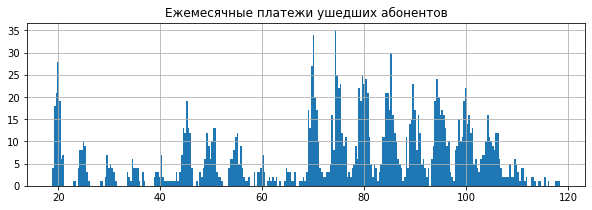

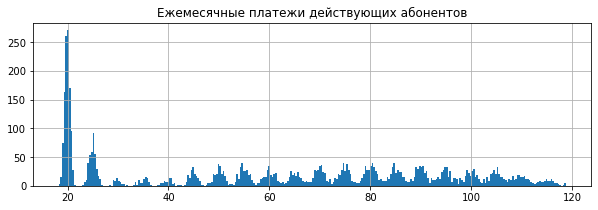

In [ ]:
contract_left.hist('MonthlyCharges', bins=300, figsize=(10,3))
plt.title('Ежемесячные платежи ушедших абонентов')
plt.show()

contract_stay.hist('MonthlyCharges', bins=300, figsize=(10,3))
plt.title('Ежемесячные платежи действующих абонентов')
plt.show()

 - Ежемесячные платежи в целом имеют вид локального нормального распределения с шагом 5 у.е. Возможно большинство услуг предоставляется пакетно со стоимостью в 5 у.е., а при израсходовании данного пакета услуг идет доплата за сверх использованный объем.
 - Для действующих абонентов количество клиентов по ежемесячным платежам приблизительно одинаково в диапазоне от 45 - 105 у.е. Резко выделяется тариф в 20-25 у.е. возможно это только обязательная абонентская плата.
 - Для ушедших абонентов выделяется диапазон от 70 - 110 у.е. В этом диапазоне сосредоточена основная масса ушедших клиентов.

Расчитаем для каждой группы статистические показатели: средние, минимальные и максимальные значения, медиану и величины 25% и 75%квартилей.

In [ ]:
stat_stay = (contract_stay.describe())
stat_left = contract_left.describe()
stat_stay.join(stat_left, lsuffix='_s', rsuffix='_l').rename(
    columns={'MonthlyCharges_s':'Ежемесячный платеж действующих абонентов',
            'MonthlyCharges_l':'Ежемесячный платеж ушедших абонентов',
            'TotalCharges_s':'Общая выручка действующих абонентов',
            'TotalCharges_l':'Общая выручка ушедших абонентов'})[[
    'Ежемесячный платеж действующих абонентов',
    'Ежемесячный платеж ушедших абонентов',
    'Общая выручка действующих абонентов',
    'Общая выручка ушедших абонентов'
                                                                ]]

,Ежемесячный платеж действующих абонентов,Ежемесячный платеж ушедших абонентов,Общая выручка действующих абонентов,Общая выручка ушедших абонентов
count,5174.000000,1869.000000,5174.000000,1869.000000
mean,61.265124,74.441332,2549.999497,1531.796094
std,31.092648,24.666053,2329.858843,1890.822994
min,18.250000,18.850000,18.800000,18.850000
25%,25.100000,56.150000,572.900000,134.500000
50%,64.425000,79.650000,1679.525000,703.550000
75%,88.400000,94.200000,4262.850000,2331.300000
max,118.750000,118.350000,8672.450000,8684.800000


Как видно из таблицы значение mean, 25%, 50%, 75% квартилей для ушедших абонентов больше, чем для действующих. Т.е. среднестатистический пользователь, который перестал пользоваться услугами данного оператора платил больше, действующих клиентов.

#### 2.3 Сравним поведение клиентов этих двух групп. Для каждой построим гистограммы, отражающие:
 -  долю пользователей телефонной связи,
 -  долю интернет-пользователей.

Доля действующих абонентов с телефоннной связью к общему количеству действующих абонентов

In [ ]:
share_stay_phone = df.loc[(df['EndDate'].isna()) &(~df['MultipleLines'].isna())].shape[0]/df.loc[
    df['EndDate'].isna()].shape[0]

Доля ушедших абонентов с телефоннной связью к общему количеству ушедших абонентов

In [ ]:
share_left_phone = df.loc[~(df['EndDate'].isna()) &(~df['MultipleLines'].isna())].shape[0]/df.loc[
    ~df['EndDate'].isna()].shape[0]

Доля действующих абонентов, которые пользуются интернетом, к общему числу действующих абонентов

In [ ]:
share_stay_int = df.loc[(df['EndDate'].isna()) &(~df['InternetService'].isna())].shape[0]/df.loc[
    df['EndDate'].isna()].shape[0]

Доля ушедших абонентов, которые пользуются интернетом, к общему числу ушедших абонентов

In [ ]:
share_left_int = df.loc[~(df['EndDate'].isna()) &(~df['InternetService'].isna())].shape[0]/df.loc[
    ~df['EndDate'].isna()].shape[0]

In [ ]:
shares = pd.DataFrame([share_stay_phone, share_left_phone, share_stay_int, share_left_int],
                  index=['Доля действующих с подключенным телефоном',
                        'Доля ушедших с подключенным телефоном',
                        'Доля действующих с подключенным интернетом',
                        'Доля ушедших с подключенным интернетом'], columns=['%'])
shares

,%
Доля действующих с подключенным телефоном,0.901044
Доля ушедших с подключенным телефоном,0.909042
Доля действующих с подключенным интернетом,0.726904
Доля ушедших с подключенным интернетом,0.939540


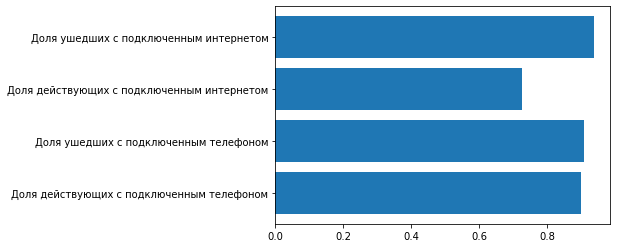

In [ ]:
plt.barh(shares.index, shares['%'])
plt.show()

**Доля ушедших и действующих клиентов, у которых был подлключен телефон приблизительно одинакова. И напротив доля ушедших клиентов, которые пользовались интернетом превышает долю действующих клиентов, которые также использовали интернет**

**Можно сделать предположение, что ушедших клиентов не устраивала цена, которую они платили за использование интернета**

In [ ]:
contract['EndDate'].unique()

array([                          'NaT', '2019-12-01T00:00:00.000000000',
       '2019-11-01T00:00:00.000000000', '2019-10-01T00:00:00.000000000',
       '2020-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [ ]:
contract['BeginDate'].min()

Timestamp('2018-04-17 00:00:00')

In [ ]:
contract['BeginDate'].max()

Timestamp('2020-02-01 00:00:00')

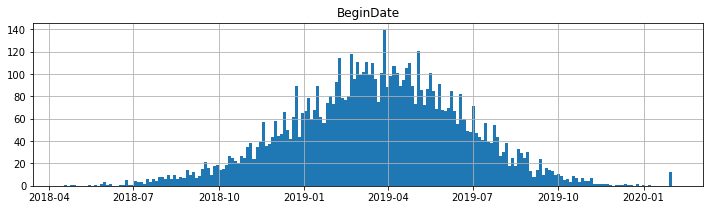

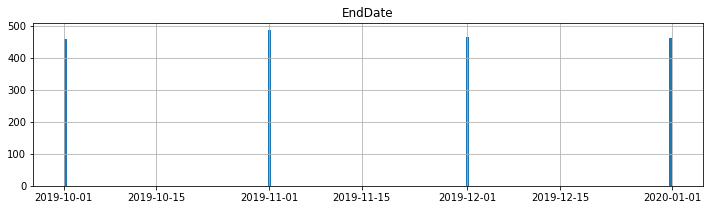

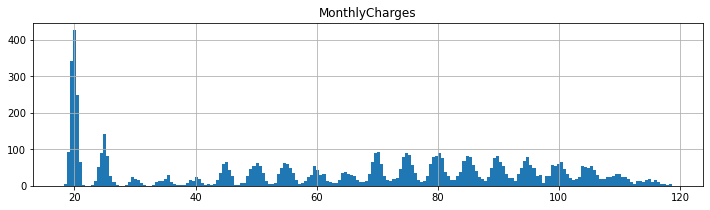

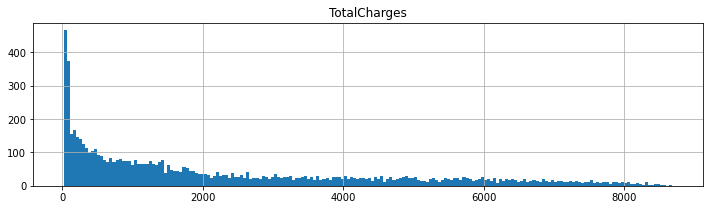

In [ ]:
hist_columns = contract.select_dtypes(exclude='object').columns.to_list()
hist_columns
for i in hist_columns:
    contract.hist(i, bins=200, figsize=(12,3))
plt.show()

В нашем датасете привлечение новых клиентов началось 2018-04-17. Далее можно выделить два периода:
 - c 2018-04 по 2019-04 . В этот период количество новых клиентов с каждым последующим месяцем росло.
 - с 2019-04 по 2020-02(время выгрузки/актуальности датасета). В этот период количество новых клиентов с каждым последующим месяцем падало. При этом скорость прироста и убыли новых клиентов приблизительно одинакова. 2020-01 новых клиентов практически нет.

 Клиенты начали уходить с 2019-10 и далее каждый месяц приблизительно равным количеством в 450-500 человек.



Определим долю клиентов, которые ушли и вообще не подключали себе интернет.

In [ ]:
df_left = df.loc[~df['EndDate'].isna()]      # те кто ушли
(df_left['InternetService'].isna().sum())*100/len(df_left)   # из ушедших, которые не подключали интернет

6.046013911182451

6% из ушедших не подключали интернет - следовательно, почти все им пользовались.

In [ ]:
internet.columns[1:].to_list()

['InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies']

Далее будет выведена гистограмма по двум группам - те кто ушли и те кто остался. По каждой группе будет расчитан % пользования каждой предоставляемой услугой интернета и способа подключения.

Начнем с группы, которая перестала пользоваться услугами данного оператора.

In [ ]:
df_left_internet = df_left[internet.columns[1:].to_list()]
df_left_internet = df_left_internet.dropna()
df_left_internet.isna().sum()

InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Функция ниже будет выполнять подсчет % определенного значения от общего числа в колонке.

In [ ]:
def counter_(df,column, value):
    counter = 0
    for i in df[column]:
        if i == value:
            counter+=1
    return counter*100/len(df[column])

В `df_result` индексом будут выступать услуги интернета, значение в колонке показывает % пользования данной услугой для категории пользователей, которые ушли.

In [ ]:
list_result = []
for i in['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']:
    list_result.append(counter_(df_left_internet, i, 'Yes'))
df_result = pd.DataFrame(list_result, index=['OnlineSecurity','OnlineBackup','DeviceProtection'
                                             ,'TechSupport','StreamingTV','StreamingMovies'])
df_result

,0
OnlineSecurity,16.799544
OnlineBackup,29.783599
DeviceProtection,31.036446
TechSupport,17.653759
StreamingTV,46.355353
StreamingMovies,46.583144


Добавим в этот датафрейм % подключения пользователей, которые выбрали оптоволокно.

In [ ]:
counter_(df_left_internet,'InternetService', 'Fiber optic')

73.86104783599089

In [ ]:
df_result.loc['Fiber optic', 0] = counter_(df_left_internet,'InternetService', 'Fiber optic')

In [ ]:
df_result

,0
OnlineSecurity,16.799544
OnlineBackup,29.783599
DeviceProtection,31.036446
TechSupport,17.653759
StreamingTV,46.355353
StreamingMovies,46.583144
Fiber optic,73.861048


Теперь переходим к группе пользователей, которые продолжают пользоваться услугами данного оператора. И определим % пользователей в этой категории, которые вообще не подключали себе интернет.

In [ ]:
df_stay = df.loc[df['EndDate'].isna()]
(df_stay.isna().sum()['InternetService'])*100/len(df_stay)

27.309625048318516

Почти треть пользователей, которые остались не подлключали себе интернет  - это довольно много.

Далее выполним действия по созданию второй колонки в датафрейме `df_result` для действующих клиентов.

In [ ]:
df_stay_internet = df_stay[internet.columns[1:].to_list()]
df_stay_internet

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,DSL,Yes,No,Yes,Yes,Yes,No
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DSL,Yes,Yes,Yes,No,Yes,Yes
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,DSL,Yes,Yes,Yes,Yes,Yes,No
...,...,...,...,...,...,...,...
7038,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7039,DSL,Yes,No,Yes,Yes,Yes,Yes
7040,Fiber optic,No,Yes,Yes,No,Yes,Yes
7041,DSL,Yes,No,No,No,No,No


In [ ]:
list_result = []
for i in['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']:
    list_result.append(counter_(df_stay_internet, i, 'Yes'))
list_result.append(0)
df_result[1]= list_result
df_result.loc['Fiber optic', 1] = counter_(df_stay_internet,'InternetService', 'Fiber optic')
df_result

,0,1
OnlineSecurity,16.799544,33.320448
OnlineBackup,29.783599,36.838036
DeviceProtection,31.036446,36.277542
TechSupport,17.653759,33.513722
StreamingTV,46.355353,36.586780
StreamingMovies,46.583144,36.992656
Fiber optic,73.861048,34.770004


Построим сравнительную гистограмму по двум группам и каждой услуге интернета и способа его подлключения.

In [ ]:
df_result.index=['Блок. опасных сайтов','Облачн. хр-ще для Backup', 'Антивирус',
                 'Выделенная линия тех. поддержки', 'Стрим. ТВ','Стрим. фильмы','Оптоволокно']

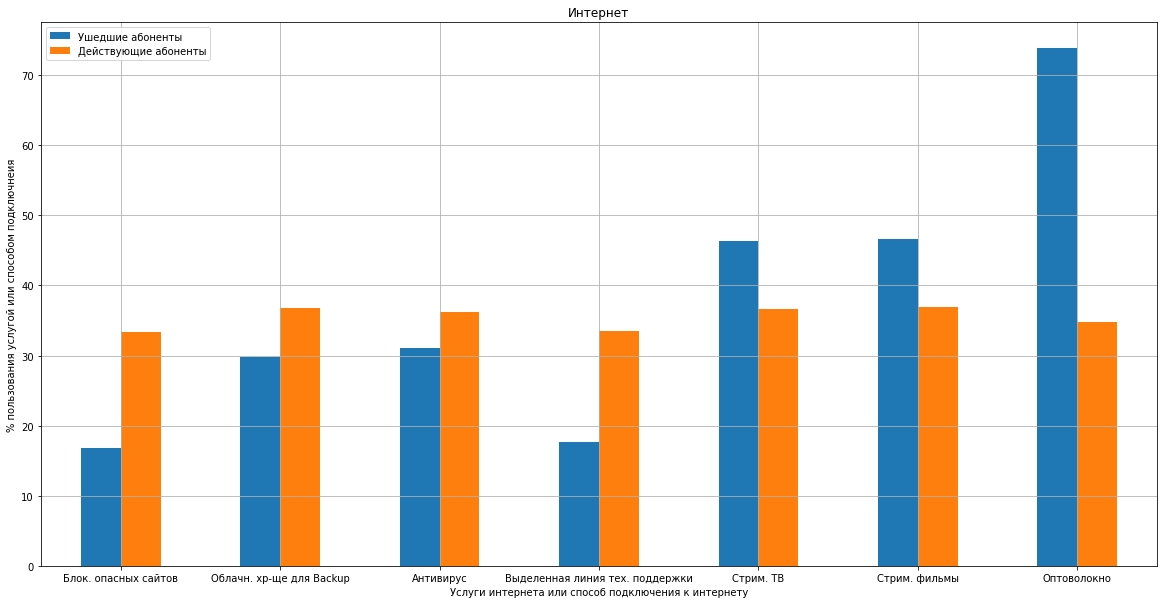

In [ ]:
df_result.plot(kind='bar', figsize=(20,10), grid=True, rot=0)
plt.legend(['Ушедшие абоненты', 'Действующие абоненты'])
plt.xlabel('Услуги интернета или способ подключения к интернету')
plt.ylabel('% пользования услугой или способом подключнеия')
plt.title('Интернет')
plt.show()

 - Для тех клиентов, которые ушли можно выделить то, что почти все они (более 70%) выбрали способ подключения - оптоволокно. В отличие от оставшихся клиентов, у которых данный способ подключения выбрали около одной трети от всех в данной группе, которые пользовались интернетом.
 - Около 45% из ушедших пользовались стримТВ и стримФильмами, в отличие от оставшихся у которых эта цифра около 38%
 - Также можно выделить, что процентном соотношении от общего числа в каждой группе выделенной линией тех. поддержки пользовалось в два раза меньше людей, которые ушли по стравнению с теми, кто продолжает пользоваться. Аналогичная ситуация также и по услуге блокировки опасных сайтов.


Далее построим такую же сравнительную гистограмму для персональных данных пользователей.

In [ ]:
personal.columns[1:]

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')

In [ ]:
df_left_personal = df_left[personal.columns[1:]]
df_left_personal

,gender,SeniorCitizen,Partner,Dependents
2,Male,0,No,No
4,Female,0,No,No
5,Female,0,No,No
8,Female,0,Yes,No
12,Male,0,No,No
...,...,...,...,...
1883,Male,0,No,No
1884,Female,0,No,No
1885,Male,1,No,No
1886,Female,0,No,No


In [ ]:
list_result = []
for i in ['Partner', 'Dependents']:
    list_result.append(counter_(df_left_personal, i, 'Yes'))
df_result_personal = pd.DataFrame(list_result, index=['Partner', 'Dependents'])
df_result_personal

,0
Partner,35.794543
Dependents,17.442483


In [ ]:
df_result_personal.loc['SeniorCitizen'] = counter_(df_left_personal, 'SeniorCitizen', 1)
df_result_personal.loc['Male', 0 ] = counter_(df_left_personal, 'gender', 'Male')
df_result_personal

,0
Partner,35.794543
Dependents,17.442483
SeniorCitizen,25.468165
Male,49.759230


In [ ]:
df_stay_personal = df_stay[personal.columns[1:]]
df_stay_personal

,gender,SeniorCitizen,Partner,Dependents
0,Female,0,Yes,Yes
1,Male,0,No,Yes
3,Female,0,Yes,Yes
6,Male,0,Yes,Yes
7,Female,0,Yes,Yes
...,...,...,...,...
7038,Female,0,No,No
7039,Male,0,Yes,Yes
7040,Female,0,Yes,Yes
7041,Female,0,Yes,Yes


In [ ]:
for i in ['Partner', 'Dependents']:
    df_result_personal.loc[i, 1] = counter_(df_stay_personal, i, 'Yes')
df_result_personal.loc['SeniorCitizen',1] = counter_(df_stay_personal, 'SeniorCitizen', 1)
df_result_personal.loc['Male',1] = counter_(df_stay_personal, 'gender', 'Male')
df_result_personal

,0,1
Partner,35.794543,52.821801
Dependents,17.442483,34.480093
SeniorCitizen,25.468165,12.872053
Male,49.759230,50.734441


In [ ]:
df_result_personal.index = ['Есть супруг/супруга','Есть дети', 'Пенсионер', 'Пол муж.']

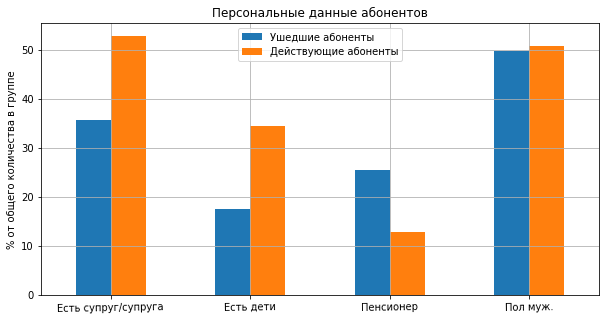

In [ ]:
df_result_personal.plot(kind='bar', figsize=(10,5), grid=True, rot=True)
plt.legend(['Ушедшие абоненты', 'Действующие абоненты'])
#plt.xlabel('Персональные данные абонента')
plt.ylabel('% от общего количества в группе')
plt.title('Персональные данные абонентов')
plt.show()

 - Для той группы, которая продолжает пользоваться услугами данного оператора количество пенсионеров составляет около 12%, в отличие от другой группы, в которой эта цифра составляет около 25%
 - Такой же двухкратный перевес наблюдается и по фактору наличия детей у абонента.
 - По наличию супруга/cупруги около 35% от общего числа из тех кто ушел имели партнера, во второй группе эта цифра составляет около 55%.
 - Разделение по гендерному признаку в каждой группе одинаково и составляет приблизительно 50/50

Ниже проанализируем эти две группы по типу контракта (долгосрочный/краткосрочный) и способу оплаты.

In [ ]:
contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,52.55
1,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,20.25
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,80.85
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,NaT,Two year,Yes,Bank transfer (automatic),21.15,1419.40
7039,6840-RESVB,2019-02-26,NaT,One year,Yes,Mailed check,84.80,1990.50
7040,2234-XADUH,2019-09-02,NaT,One year,Yes,Credit card (automatic),103.20,7362.90
7041,4801-JZAZL,2019-06-26,NaT,Month-to-month,Yes,Electronic check,29.60,346.45


Функция `plot_bar` будет выводить горизонтальные гистограммы из заданного датафрейма по  заданным столбцам.

In [ ]:
def plot_bar(df, list_column):
    for column in list_column:
        index_ = df[column].value_counts().index
        values_ = df[column].value_counts(normalize=True).values
        plt.barh(index_, values_, tick_label=index_)
        #plt.tick_label(values_)
        print(values_)
        plt.title(column)
        plt.show()

In [ ]:
contarct_stay = contract.loc[contract['EndDate'].isna()]
contarct_left = contract.loc[~contract['EndDate'].isna()]

[0.88550027 0.08881755 0.02568218]


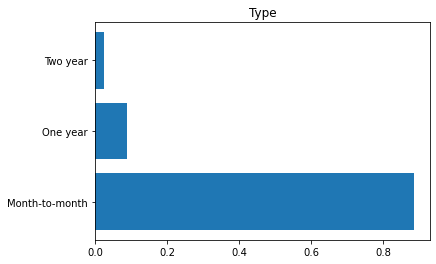

[0.57303371 0.16479401 0.13804173 0.12413055]


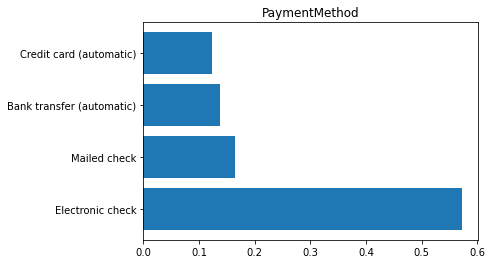

[0.42906842 0.31832238 0.2526092 ]


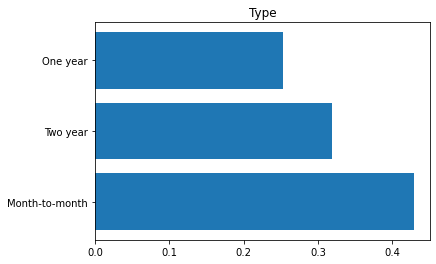

[0.25202938 0.25009664 0.24932354 0.24855044]


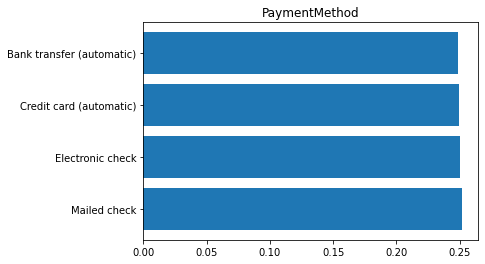

In [ ]:
plot_bar(contarct_left, ['Type', 'PaymentMethod'])
plot_bar(contarct_stay, ['Type', 'PaymentMethod'])

 - Помесячную оплату в основном выбирали в группе клиентов, которые в дальнейшем ушли. Для действующих клиентов доля двухгодовых контрактов составила 31%, доля годовых контрактов - 25%
 - По способу у действующих клиентов одинаковое предпочтение между автоплатежами и обычными платежами, тогда как в другой группе предпочтение отдано на оплату в ручном режиме.

**ВЫВОДЫ ПО ИССЛЕДОВАТЕЛЬСКОМУ АНАЛИЗУ**

 - Ежемесячные платежи в целом имеют вид локального нормального распределения с шагом 5 у.е. Возможно большинство услуг предоставляется пакетно со стоимостью в 5 у.е., а при израсходовании данного пакета услуг идет доплата за сверх использованный объем.
 - Для действующих абонентов количество клиентов по ежемесячным платежам приблизительно одинаково в диапазоне от 45 - 105 у.е. Резко выделяется тариф в 20-25 у.е. возможно это только обязательная абонентская плата.
 - Для ушедших абонентов выделяется диапазон от 70 - 110 у.е. В этом диапазоне сосредоточена основная масса ушедших клиентов.

Как видно из таблицы значение mean, 25%, 50%, 75% квартилей для ушедших абонентов больше, чем для действующих. Т.е. среднестатистический пользователь, который перестал пользоваться услугами данного оператора платил больше, действующих клиентов.

Доля ушедших и действующих клиентов, у которых был подлключен телефон приблизительно одинакова. И напротив доля ушедших клиентов, которые пользовались интернетом превышает долю действующих клиентов, которые также использовали интернет

Можно сделать предположение, что ушедших клиентов не устраивала цена, которую они платили за использование интернета

В нашем датасете привлечение новых клиентов началось 2018-04-17. Далее можно выделить два периода:
 - c 2018-04 по 2019-04 . В этот период количество новых клиентов с каждым последующим месяцем росло.
 - с 2019-04 по 2020-02(время выгрузки/актуальности датасета). В этот период количество новых клиентов с каждым последующим месяцем падало. При этом скорость прироста и убыли новых клиентов приблизительно одинакова. 2020-01 новых клиентов практически нет.

 Клиенты начали уходить с 2019-10 и далее каждый месяц приблизительно равным количеством в 450-500 человек.

6% из ушедших не подключали интернет - следовательно, почти все им пользовались.

Почти треть пользователей, которые остались не подлключали себе интернет  - это довольно много.

 - Для тех клиентов, которые ушли можно выделить то, что почти все они (более 70%) выбрали способ подключения - оптоволокно. В отличие от оставшихся клиентов, у которых данный способ подключения выбрали около одной трети от всех в данной группе, которые пользовались интернетом.
 - Около 45% из ушедших пользовались стримТВ и стримФильмами, в отличие от оставшихся у которых эта цифра около 38%
 - Также можно выделить, что процентном соотношении от общего числа в каждой группе выделенной линией тех. поддержки пользовалось в два раза меньше людей, которые ушли по стравнению с теми, кто продолжает пользоваться. Аналогичная ситуация также и по услуге блокировки опасных сайтов.

 - Для той группы, которая продолжает пользоваться услугами данного оператора количество пенсионеров составляет около 12%, в отличие от другой группы, в которой эта цифра составляет около 25%
 - Такой же двухкратный перевес наблюдается и по фактору наличия детей у абонента.
 - По наличию супруга/cупруги около 35% от общего числа из тех кто ушел имели партнера, во второй группе эта цифра составляет около 55%.
 - Разделение по гендерному признаку в каждой группе одинаково и составляет приблизительно 50/50

 - Помесячную оплату в основном выбирали в группе клиентов, которые в дальнейшем ушли. Для действующих клиентов доля двухгодовых контрактов составила 31%, доля годовых контрактов - 25%
 - По способу у действующих клиентов одинаковое предпочтение между автоплатежами и обычными платежами, тогда как в другой группе предпочтение отдано на оплату в ручном режиме.

In [ ]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,churn,delta
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,52.55,DSL,Yes,...,Yes,Yes,No,Female,0,Yes,Yes,NaN,0,0
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,20.25,NaN,NaN,...,NaN,NaN,NaN,Male,0,No,Yes,No,0,0
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,No,No,No,Male,0,No,No,No,1,479
3,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,80.85,DSL,Yes,...,No,Yes,Yes,Female,0,Yes,Yes,No,0,0
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,...,No,No,No,Female,0,No,No,No,1,279


In [ ]:
phik_overview = df.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'churn', 'delta']


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,churn,delta
customerID,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
BeginDate,1.0,1.00,0.52,0.13,0.04,0.10,0.19,0.00,0.11,0.14,...,0.05,0.06,0.06,0.09,0.14,0.14,0.08,0.03,0.49,0.98
EndDate,1.0,0.52,1.00,0.36,0.16,0.21,0.32,0.25,0.20,0.23,...,0.22,0.03,0.03,0.00,0.12,0.12,0.13,0.03,1.00,0.03
Type,1.0,0.13,0.36,1.00,0.11,0.28,0.39,0.51,0.12,0.25,...,0.29,0.16,0.17,0.00,0.09,0.18,0.15,0.07,0.25,0.04
PaperlessBilling,1.0,0.04,0.16,0.11,1.00,0.37,0.47,0.21,0.36,0.22,...,0.14,0.18,0.16,0.00,0.24,0.01,0.17,0.27,0.30,0.05
PaymentMethod,1.0,0.10,0.21,0.28,0.37,1.00,0.40,0.35,0.43,0.37,...,0.37,0.25,0.26,0.00,0.29,0.24,0.22,0.37,0.45,0.00
MonthlyCharges,1.0,0.19,0.32,0.39,0.47,0.40,1.00,0.76,0.95,0.36,...,0.40,0.73,0.73,0.01,0.30,0.20,0.18,0.48,0.36,0.02
TotalCharges,1.0,0.00,0.25,0.51,0.21,0.35,0.76,1.00,0.35,0.44,...,0.46,0.55,0.56,0.00,0.15,0.42,0.11,0.61,0.28,0.01
InternetService,1.0,0.11,0.20,0.12,0.36,0.43,0.95,0.35,1.00,0.34,...,0.33,0.26,0.25,0.00,0.31,0.00,0.21,0.34,0.37,0.03
OnlineSecurity,1.0,0.14,0.23,0.25,0.22,0.37,0.36,0.44,0.34,1.00,...,0.42,0.07,0.08,0.02,0.17,0.27,0.24,0.08,0.43,0.03


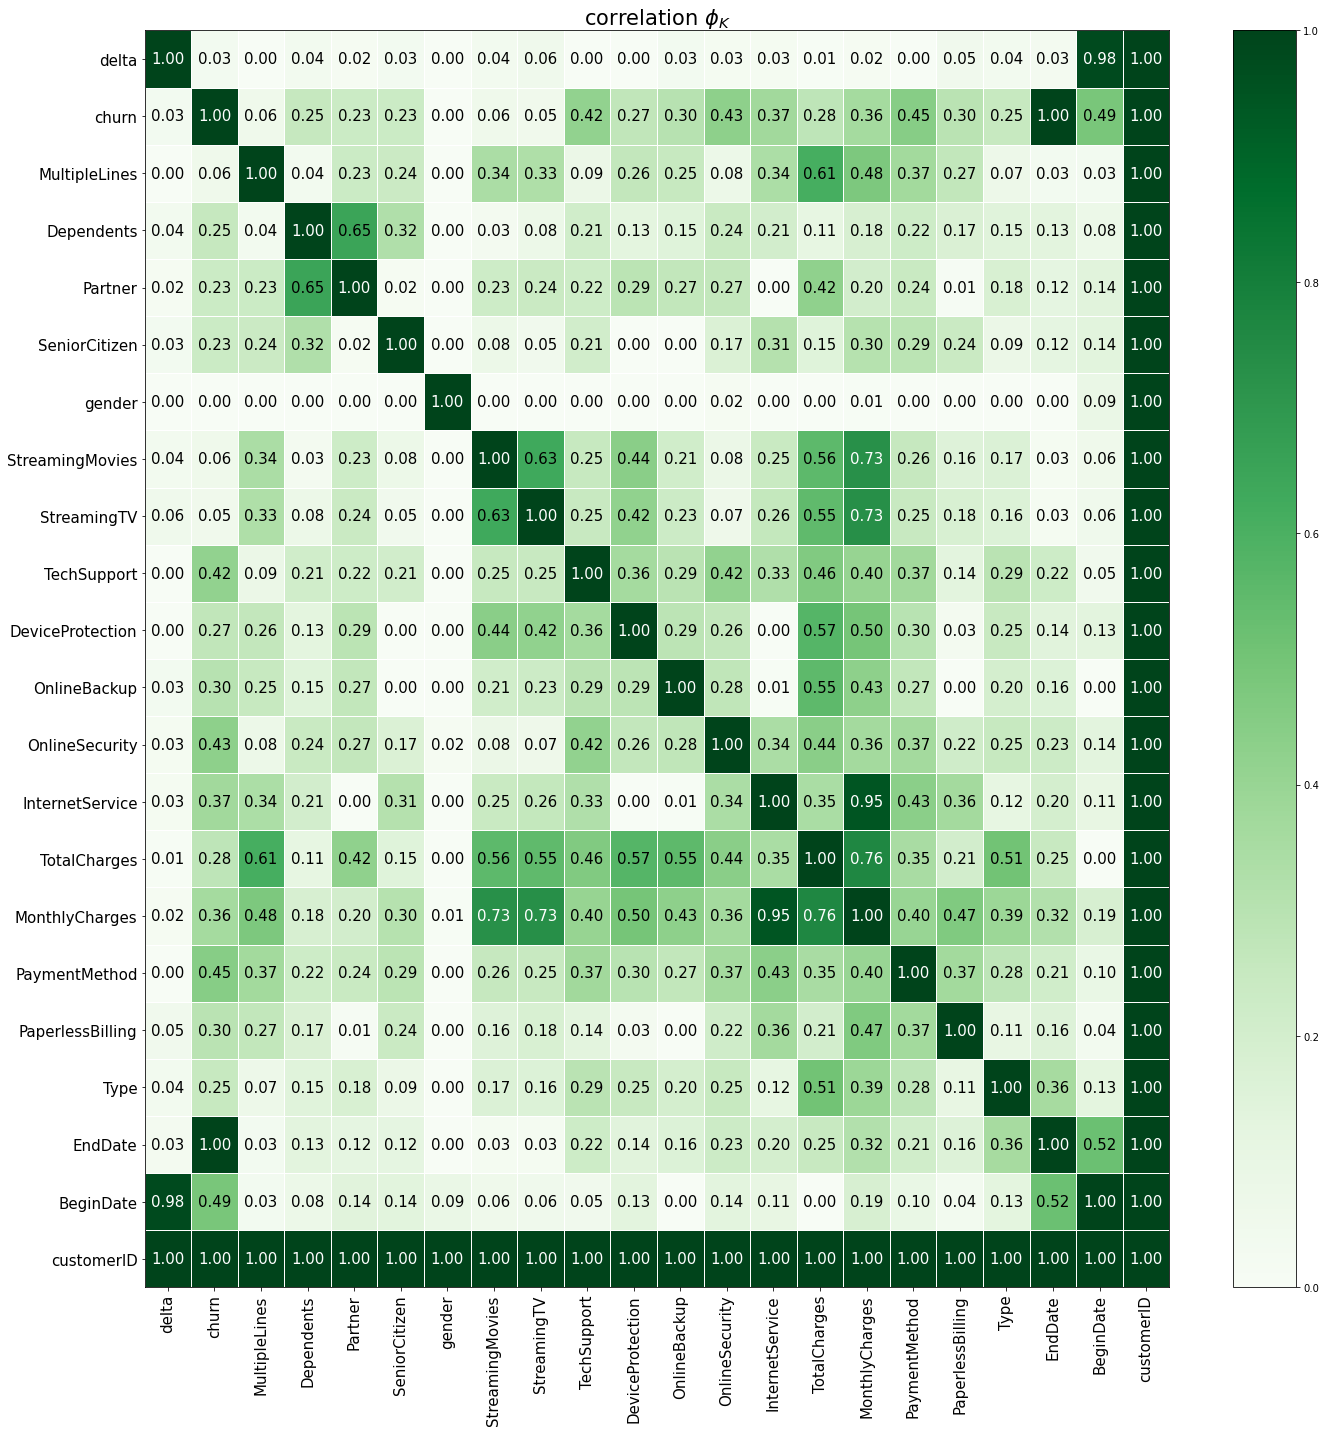

In [ ]:

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=1.5,
                        figsize=(20, 20))
plt.tight_layout()

## Шаг 3. Обучите модель

Найдите лучшую модель прогнозирования оттока. За критерий оценки качества модели возьмите метрику ROC-AUC. Значение метрики должно быть не менее 0.78. Для интерпретируемости модели дополнительно выведите значение accuracy каждой модели. Рассмотрите следующие классы моделей:
 - решающее дерево,
 - бустинги,
 - нейронные сети.

Проанализируем количественные признаки датасета `df` на наличие выбросов.

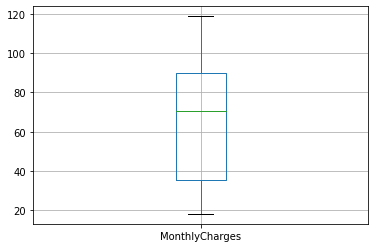

In [ ]:
df.boxplot('MonthlyCharges')
plt.show()

In [ ]:
df.loc[df['MonthlyCharges']>=120]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines


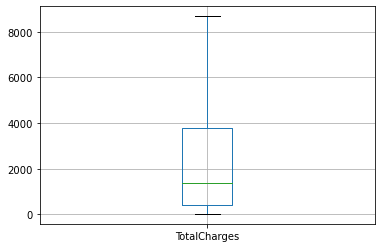

In [ ]:
df.boxplot('TotalCharges')
plt.show()

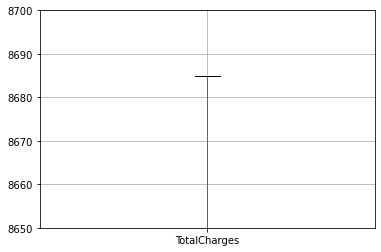

In [ ]:
df.boxplot('TotalCharges')
plt.ylim(8650, 8700)
plt.show()

In [ ]:
df.loc[df['TotalCharges']>=8685]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines


Выбросов нет.

Создадим целевую переменную `churn`. Если клиент не уходил, значит в `EndDate` будет значение `NaT`. Если же клиент перестал пользоваться услугами оператора, то в `EndDate` будет дата ухода.

In [ ]:
df['churn'] = ~df['EndDate'].isna()
df['churn'] = df['churn'].astype(int)
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,churn
0,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,52.55,DSL,Yes,...,Yes,Yes,Yes,No,Female,0,Yes,Yes,NaN,0
1,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,20.25,NaN,NaN,...,NaN,NaN,NaN,NaN,Male,0,No,Yes,No,0
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,No,No,No,No,Male,0,No,No,No,1
3,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,80.85,DSL,Yes,...,Yes,No,Yes,Yes,Female,0,Yes,Yes,No,0
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,...,No,No,No,No,Female,0,No,No,No,1


Создадим дополнительный признак `delta`, который будет показывать длительность пользования клиентом услугами оператора в днях на 01 февраля 2020 (время актуальности датасета). В дальнейшем для моделирования будем использовать, только признак  `delta` вместо `BeginDate` и `EndDate`.

In [ ]:
df['EndDate'] = df['EndDate'].fillna('2020-02-01')
df['delta'] = df['EndDate'] - df['BeginDate']
df['delta'] = df['delta'].dt.days.astype('int16')
df.head()


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,churn,delta
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,52.55,DSL,Yes,...,Yes,Yes,No,Female,0,Yes,Yes,NaN,0,0
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,20.25,NaN,NaN,...,NaN,NaN,NaN,Male,0,No,Yes,No,0,0
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,No,No,No,Male,0,No,No,No,1,479
3,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,80.85,DSL,Yes,...,No,Yes,Yes,Female,0,Yes,Yes,No,0,0
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,...,No,No,No,Female,0,No,No,No,1,279


In [ ]:
df[['BeginDate', 'EndDate', 'churn', 'delta']]

,BeginDate,EndDate,churn,delta
0,2020-02-01,2020-02-01,0,0
1,2020-02-01,2020-02-01,0,0
2,2018-08-09,2019-12-01,1,479
3,2020-02-01,2020-02-01,0,0
4,2019-01-26,2019-11-01,1,279
...,...,...,...,...
7038,2019-01-21,2020-02-01,0,376
7039,2019-02-26,2020-02-01,0,340
7040,2019-09-02,2020-02-01,0,152
7041,2019-06-26,2020-02-01,0,220


In [ ]:
df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,churn,delta
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,52.55,DSL,Yes,...,Yes,Yes,No,Female,0,Yes,Yes,NaN,0,0
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,20.25,NaN,NaN,...,NaN,NaN,NaN,Male,0,No,Yes,No,0,0
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,No,No,No,Male,0,No,No,No,1,479
3,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,80.85,DSL,Yes,...,No,Yes,Yes,Female,0,Yes,Yes,No,0,0
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,...,No,No,No,Female,0,No,No,No,1,279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,2020-02-01,Two year,Yes,Bank transfer (automatic),21.15,1419.40,NaN,NaN,...,NaN,NaN,NaN,Female,0,No,No,No,0,376
7039,6840-RESVB,2019-02-26,2020-02-01,One year,Yes,Mailed check,84.80,1990.50,DSL,Yes,...,Yes,Yes,Yes,Male,0,Yes,Yes,Yes,0,340
7040,2234-XADUH,2019-09-02,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,Fiber optic,No,...,No,Yes,Yes,Female,0,Yes,Yes,Yes,0,152
7041,4801-JZAZL,2019-06-26,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,DSL,Yes,...,No,No,No,Female,0,Yes,Yes,NaN,0,220


Признак `customerID` не несет никакой информативной составляющей. В дальнейшем исключим его из датасета. Предварительно сделаем привязку `customerID` к индексам датасета через словарь `dict_id`, на тот случай если потребуется узнать Id клиента.

In [ ]:
dict_id = df['customerID'].to_dict()
dict_id[0]

'4472-LVYGI'

Удалим столбцы `customerID`, `BeginDate`, `EndDate` и перезапишем наш датасет в переменную `df_preprocessed`

In [ ]:
list_remove = ['customerID', 'BeginDate', 'EndDate']
df_preprocessed = df.drop(list_remove, axis=1)
df_preprocessed.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,churn,delta
0,Two year,Yes,Bank transfer (automatic),52.55,52.55,DSL,Yes,No,Yes,Yes,Yes,No,Female,0,Yes,Yes,NaN,0,0
1,Two year,No,Mailed check,20.25,20.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,No,Yes,No,0,0
2,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No,1,479
3,Two year,No,Mailed check,80.85,80.85,DSL,Yes,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,No,0,0
4,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No,1,279


Наш датасет содержит количественные признаки `MonthlyCharges`, `TotalCharges`, `delta`, которые отмасштабируем с помощью `StandardScaler`. Также датасет содержит категориальные признаки, которые перекодируем с помощью `OneHotEncoder`

При объединении четырех исходных таблиц из SQL в один датафрейм образовались `Nan`, в том случае если клиент не пользовался, а точнее вовсе не подключал данную услугу. Поэтому заполним все `Nan` значением `not_used`

In [ ]:
df_preprocessed.isna().sum()

Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
churn                  0
delta                  0
dtype: int64

In [ ]:
df_preprocessed = df_preprocessed.fillna('not_used')
df_preprocessed.isna().sum()

Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
churn               0
delta               0
dtype: int64

Пропущенных значений в датасете нет. Теперь разобьем нат датасет на `train`, `valid` и `test` в соотношение 60:20:20

In [ ]:
target = df_preprocessed['churn']
features = df_preprocessed.drop('churn', axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(features, target,
                                                                            test_size=0.4, random_state=12345,
                                                                              stratify = target)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid,
                                                                            test_size=0.5, random_state=12345,
                                                                              stratify = target_valid)

Выведем размерность выборок для проверки.

In [ ]:
list_data = [features_train, features_valid, features_test, target_train, target_valid, target_test]
for i in list_data:
    print(i.shape)

(4225, 18)
(1409, 18)
(1409, 18)
(4225,)
(1409,)
(1409,)


Выведем распределение нашей целевой переменной в каждой выборке.

In [ ]:
list_vc = [target, target_valid, target_test]
for i in list_vc:
    display(i.value_counts(normalize=True))

0    0.73463
1    0.26537
Name: churn, dtype: float64

0    0.734564
1    0.265436
Name: churn, dtype: float64

0    0.734564
1    0.265436
Name: churn, dtype: float64

Наблюдаем дисбалланс классов.

Выделим признаки для масштабированимя в переменную `columns_to_scale`, далее выполним масштабирование с помощью `StandardScaler` c fit для `train` и с transform для `valid` и `test`

In [ ]:
columns_to_scale = df_preprocessed.select_dtypes(exclude=['object', 'int32', 'int64']).columns.to_list()
columns_to_scale

['MonthlyCharges', 'TotalCharges', 'delta']

In [ ]:
scaler = StandardScaler()
scaler.fit(features_train[columns_to_scale])
features_train[columns_to_scale] = scaler.transform(features_train[columns_to_scale])
features_valid[columns_to_scale] = scaler.transform(features_valid[columns_to_scale])
features_test[columns_to_scale] = scaler.transform(features_test[columns_to_scale])


In [ ]:
features_train

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,delta
6500,One year,No,Electronic check,1.183744,0.693251,Fiber optic,No,No,Yes,No,Yes,Yes,Male,0,Yes,Yes,Yes,-0.195607
6740,Two year,Yes,Credit card (automatic),0.656344,1.713045,DSL,Yes,Yes,Yes,No,Yes,Yes,Female,1,Yes,No,Yes,0.263919
2532,Two year,Yes,Bank transfer (automatic),-0.839614,0.027302,DSL,No,No,No,Yes,Yes,No,Male,0,Yes,No,not_used,1.418626
4174,Month-to-month,No,Mailed check,-1.499693,-1.003272,not_used,not_used,not_used,not_used,not_used,not_used,not_used,Female,0,No,No,No,0.570270
5020,One year,Yes,Mailed check,-0.320506,0.381703,DSL,No,Yes,No,Yes,No,No,Male,0,No,No,No,0.970883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4628,Two year,Yes,Credit card (automatic),-1.468181,-0.477594,not_used,not_used,not_used,not_used,not_used,not_used,not_used,Male,0,No,No,No,0.582053
987,Month-to-month,Yes,Electronic check,1.250084,-0.502621,Fiber optic,No,Yes,No,No,Yes,Yes,Female,0,Yes,No,Yes,0.275702
1685,One year,Yes,Credit card (automatic),1.362861,1.496893,Fiber optic,Yes,Yes,No,Yes,Yes,Yes,Male,0,No,No,No,-1.291401
2340,One year,No,Mailed check,-1.471498,-0.990559,not_used,not_used,not_used,not_used,not_used,not_used,not_used,Male,0,No,No,No,0.876621


In [ ]:
df_preprocessed.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,churn,delta
0,Two year,Yes,Bank transfer (automatic),52.55,52.55,DSL,Yes,No,Yes,Yes,Yes,No,Female,0,Yes,Yes,not_used,0,0
1,Two year,No,Mailed check,20.25,20.25,not_used,not_used,not_used,not_used,not_used,not_used,not_used,Male,0,No,Yes,No,0,0
2,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No,1,479
3,Two year,No,Mailed check,80.85,80.85,DSL,Yes,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,No,0,0
4,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No,1,279


Выделими категориальные признаки для перекодировки с помощью `OneHotEncoder` в переменную `columns_to_ohe`

In [ ]:
columns_to_ohe = df_preprocessed.select_dtypes(include='object').columns.to_list()
columns_to_ohe


['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'gender',
 'Partner',
 'Dependents',
 'MultipleLines']

Выполним fit для `train` и transform для `valid` и `test`

In [ ]:
ohe_coder = OneHotEncoder(drop='first').fit(features_train[columns_to_ohe])
ohe_coder.categories_
features_train_ohe = ohe_coder.transform(features_train[columns_to_ohe]).toarray()
features_valid_ohe = ohe_coder.transform(features_valid[columns_to_ohe]).toarray()
features_test_ohe = ohe_coder.transform(features_test[columns_to_ohe]).toarray()

In [ ]:
ohe_coder.categories_

[array(['Month-to-month', 'One year', 'Two year'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['Bank transfer (automatic)', 'Credit card (automatic)',
        'Electronic check', 'Mailed check'], dtype=object),
 array(['DSL', 'Fiber optic', 'not_used'], dtype=object),
 array(['No', 'Yes', 'not_used'], dtype=object),
 array(['No', 'Yes', 'not_used'], dtype=object),
 array(['No', 'Yes', 'not_used'], dtype=object),
 array(['No', 'Yes', 'not_used'], dtype=object),
 array(['No', 'Yes', 'not_used'], dtype=object),
 array(['No', 'Yes', 'not_used'], dtype=object),
 array(['Female', 'Male'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes', 'not_used'], dtype=object)]

Для изначального отображения нашего датафрейма создадим `columns_ohe_df`. Имя новой колонки будет сконкатенировано через символ `_` со старым именем колонки и значением в этой колонке (исключая первое значение)

In [ ]:
columns_ohe_df = []
for i in range(len(columns_to_ohe)):
    for j in range(1, len(ohe_coder.categories_[i])):
        columns_ohe_df.append(columns_to_ohe[i]+'_'+ohe_coder.categories_[i][j])


In [ ]:
columns_ohe_df

['Type_One year',
 'Type_Two year',
 'PaperlessBilling_Yes',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check',
 'InternetService_Fiber optic',
 'InternetService_not_used',
 'OnlineSecurity_Yes',
 'OnlineSecurity_not_used',
 'OnlineBackup_Yes',
 'OnlineBackup_not_used',
 'DeviceProtection_Yes',
 'DeviceProtection_not_used',
 'TechSupport_Yes',
 'TechSupport_not_used',
 'StreamingTV_Yes',
 'StreamingTV_not_used',
 'StreamingMovies_Yes',
 'StreamingMovies_not_used',
 'gender_Male',
 'Partner_Yes',
 'Dependents_Yes',
 'MultipleLines_Yes',
 'MultipleLines_not_used']

`features_train_ohe`, `features_valid_ohe`, `features_test_ohe` эти датафреймы будут содержать перекодированные категориальные признаки с добавлением отмасштабированных количественных признаков.

In [ ]:
features_train_ohe = pd.DataFrame(features_train_ohe, columns = columns_ohe_df, index = features_train.index)
features_valid_ohe = pd.DataFrame(features_valid_ohe, columns = columns_ohe_df, index = features_valid.index)
features_test_ohe = pd.DataFrame(features_test_ohe, columns = columns_ohe_df, index = features_test.index)
for i in columns_to_scale:
    features_train_ohe[i] = features_train[i]
    features_valid_ohe[i] = features_valid[i]
    features_test_ohe[i] = features_test[i]


In [ ]:
features_train_dt = features_train_ohe
features_valid_dt = features_valid_ohe
features_test_dt = features_test_ohe

In [ ]:
features_train_dt.head()

,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_not_used,OnlineSecurity_Yes,OnlineSecurity_not_used,...,StreamingMovies_Yes,StreamingMovies_not_used,gender_Male,Partner_Yes,Dependents_Yes,MultipleLines_Yes,MultipleLines_not_used,MonthlyCharges,TotalCharges,delta
6500,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.183744,0.693251,-0.195607
6740,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.656344,1.713045,0.263919
2532,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,-0.839614,0.027302,1.418626
4174,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.499693,-1.003272,0.570270
5020,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.320506,0.381703,0.970883


Датафреймы `features_train_dt`, `features_valid_dt` будем использвоать для обучения решающего дерева.

### 3.1 Решающее дерево

In [ ]:
best_model = None
auc_roc_max = 0
for depth in range(1, 20):
    model = DecisionTreeClassifier(random_state = 12345, max_depth = depth, class_weight = 'balanced')
    model.fit(features_train_dt, target_train)
    probabilities_valid = model.predict_proba(features_valid_dt)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    if auc_roc > auc_roc_max:
        auc_roc_max = auc_roc
        best_model = depth

    print('max_depth =',depth, '\tauc_roc = ', round(auc_roc,4))
print()
print('depth лучшей модели = ', best_model, 'auc_roc = ', round(auc_roc_max,4))

max_depth = 1 	auc_roc =  0.6457
max_depth = 2 	auc_roc =  0.7331
max_depth = 3 	auc_roc =  0.7903
max_depth = 4 	auc_roc =  0.814
max_depth = 5 	auc_roc =  0.821
max_depth = 6 	auc_roc =  0.8137
max_depth = 7 	auc_roc =  0.7961
max_depth = 8 	auc_roc =  0.7903
max_depth = 9 	auc_roc =  0.7707
max_depth = 10 	auc_roc =  0.7598
max_depth = 11 	auc_roc =  0.7461
max_depth = 12 	auc_roc =  0.7413
max_depth = 13 	auc_roc =  0.7184
max_depth = 14 	auc_roc =  0.702
max_depth = 15 	auc_roc =  0.6861
max_depth = 16 	auc_roc =  0.6793
max_depth = 17 	auc_roc =  0.6741
max_depth = 18 	auc_roc =  0.6697
max_depth = 19 	auc_roc =  0.6582

depth лучшей модели =  5 auc_roc =  0.821


In [ ]:
model = DecisionTreeClassifier(random_state = 12345, max_depth = 5, class_weight = 'balanced')
model.fit(features_train_dt, target_train)
probabilities_valid = model.predict_proba(features_valid_dt)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_dt = roc_auc_score(target_valid, probabilities_one_valid)
print( 'auc_roc = ', round(auc_roc_dt,4))

auc_roc =  0.821


In [ ]:
model = DecisionTreeClassifier(random_state = 12345, max_depth = 5, class_weight = 'balanced')
model.fit(features_train_dt, target_train)
predict = model.predict(features_valid_dt)
accuracy_dt = accuracy_score(target_valid, predict)
print( 'accuracy = ', round(accuracy_dt,4))

accuracy =  0.7097


### 3.2 Catboost

CatBoost может работать с категориальными признаками, поэтому будем использовать `features_train`

In [ ]:
features_train.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,delta
6500,One year,No,Electronic check,1.183744,0.693251,Fiber optic,No,No,Yes,No,Yes,Yes,Male,0,Yes,Yes,Yes,-0.195607
6740,Two year,Yes,Credit card (automatic),0.656344,1.713045,DSL,Yes,Yes,Yes,No,Yes,Yes,Female,1,Yes,No,Yes,0.263919
2532,Two year,Yes,Bank transfer (automatic),-0.839614,0.027302,DSL,No,No,No,Yes,Yes,No,Male,0,Yes,No,not_used,1.418626
4174,Month-to-month,No,Mailed check,-1.499693,-1.003272,not_used,not_used,not_used,not_used,not_used,not_used,not_used,Female,0,No,No,No,0.570270
5020,One year,Yes,Mailed check,-0.320506,0.381703,DSL,No,Yes,No,Yes,No,No,Male,0,No,No,No,0.970883


In [ ]:
cat_features = features_train.select_dtypes(include='object').columns.to_list()
cat_features

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'gender',
 'Partner',
 'Dependents',
 'MultipleLines']

In [ ]:
train_pool = Pool(features_train, label=target_train,
                  cat_features=cat_features)
test_pool = Pool(features_valid, label=target_valid,
                  cat_features=cat_features)

#cb_rmse = CatBoostRegressor(loss_function='RMSE', n_estimators=1000, silent=True)
cb = CatBoostClassifier(loss_function='Logloss', iterations=893, learning_rate = 0.01,
                             depth = 6, verbose=40, eval_metric='AUC')
cb.fit(train_pool, eval_set=test_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8032396	best: 0.8032396 (0)	total: 191ms	remaining: 2m 50s
40:	test: 0.8267948	best: 0.8273192 (31)	total: 1.39s	remaining: 28.8s
80:	test: 0.8333566	best: 0.8334057 (79)	total: 2.28s	remaining: 22.9s
120:	test: 0.8345966	best: 0.8345966 (120)	total: 3.15s	remaining: 20.1s
160:	test: 0.8359865	best: 0.8359865 (160)	total: 4.16s	remaining: 18.9s
200:	test: 0.8372717	best: 0.8375197 (195)	total: 5.33s	remaining: 18.4s
240:	test: 0.8383606	best: 0.8384562 (238)	total: 6.4s	remaining: 17.3s
280:	test: 0.8390361	best: 0.8391731 (273)	total: 7.53s	remaining: 16.4s
320:	test: 0.8393281	best: 0.8394314 (297)	total: 8.5s	remaining: 15.2s
360:	test: 0.8394611	best: 0.8395205 (347)	total: 9.47s	remaining: 14s
400:	test: 0.8395748	best: 0.8396574 (390)	total: 10.3s	remaining: 12.6s
440:	test: 0.8395877	best: 0.8396574 (390)	total: 11s	remaining: 11.3s
480:	test: 0.8398848	best: 0.8398848 (478)	total: 11.8s	remaining: 10.1s
520:	test: 0.8398951	best: 0.8399649 (507)	total: 12.6s	remainin

In [ ]:
auc_roc_cb = cb.best_score_['validation']['AUC']
auc_roc_cb

0.8403601229688187

In [ ]:
auc_roc_cb = cb.best_score_['validation']['AUC']
auc_roc_cb
accuracy_cb = accuracy_score(target_valid,cb.predict(features_valid))
accuracy_cb

0.7899219304471257

### 3.3 Полносвязная нейронная сеть

В качестве базовой модели будем использовать полносвязную НС с двумя скрыми слоями с количеством нейронов в каждом 32 и 16 соответвенно. Функции активации ReLU и Sigmoid ( так как решаем задачу бинарной классификации)

In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.use_deterministic_algorithms(True)

n_in_neurons = len(features_train_dt.columns)
n_hidden_neurons_1 = 32
n_hidden_neurons_2 = 16

n_out_neurons = 1

X_train = torch.Tensor(features_train_dt.values)
X_valid = torch.Tensor(features_valid_dt.values)
X_test = torch.Tensor(features_test_dt.values)

y_train = torch.Tensor(target_train.values)
y_valid = torch.Tensor(target_valid.values)
y_test = torch.Tensor(target_test.values)



net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),

    nn.BatchNorm1d(n_hidden_neurons_1),
    #nn.Dropout(p=0.1),
    nn.ReLU(),

    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.BatchNorm1d(n_hidden_neurons_2),


    nn.Sigmoid(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons),


)


optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss =  nn.MSELoss()


roc_auc_max = 0
epoch_min = 0

num_epochs = 400
for epoch in range(num_epochs):
    optimizer.zero_grad()
    preds = net.forward(X_train).flatten()
    loss_value = (loss(preds, y_train))
    loss_value1 = sqrt(loss_value.detach().numpy())
    loss_value.backward()
    optimizer.step()
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        net.eval()
        valid_preds = net.forward(X_valid)

        auc_roc = roc_auc_score(target_valid, valid_preds.detach().numpy().flatten())

        if auc_roc >= roc_auc_max:
            roc_auc_max = auc_roc
            epoch_min = epoch
        print('roc_auc = ', auc_roc,'\tloss_value = ', loss_value1,   '\tepoch = ', epoch)
print()
print('roc_auc_max = ', roc_auc_max, '\tepoch_min = ',epoch_min)


roc_auc =  0.5928918339404273 	loss_value =  0.4557261294309133 	epoch =  0
roc_auc =  0.7127386395928595 	loss_value =  0.436149539447372 	epoch =  10
roc_auc =  0.7634451936242217 	loss_value =  0.4301481378790131 	epoch =  20
roc_auc =  0.7823916918546074 	loss_value =  0.4222503687584251 	epoch =  30
roc_auc =  0.7933555503887983 	loss_value =  0.4116760253453796 	epoch =  40
roc_auc =  0.8020253687772869 	loss_value =  0.3995622579143333 	epoch =  50
roc_auc =  0.8096360019633677 	loss_value =  0.3885665635867011 	epoch =  60
roc_auc =  0.8160066134490687 	loss_value =  0.3814520699038731 	epoch =  70
roc_auc =  0.8195225916453538 	loss_value =  0.3782695257614559 	epoch =  80
roc_auc =  0.8212327882404608 	loss_value =  0.3764624292516403 	epoch =  90
roc_auc =  0.8220362189671653 	loss_value =  0.37490986694514283 	epoch =  100
roc_auc =  0.8231289880906247 	loss_value =  0.373668552091205 	epoch =  110
roc_auc =  0.8246635149448449 	loss_value =  0.3726339201564919 	epoch =  12

Попробуем улучшить метрику и подбирем значения `n1` и `n2` с помощью функции `search_num_neur`

In [ ]:
def search_num_neur(n1,n2):
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    torch.use_deterministic_algorithms(True)

    n_in_neurons = len(features_train_dt.columns)
    n_hidden_neurons_1 = n1
    n_hidden_neurons_2 = n2
    n_out_neurons = 1

    X_train = torch.Tensor(features_train_dt.values)
    X_valid = torch.Tensor(features_valid_dt.values)
    X_test = torch.Tensor(features_test_dt.values)

    y_train = torch.Tensor(target_train.values)
    y_valid = torch.Tensor(target_valid.values)
    y_test = torch.Tensor(target_test.values)


    net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),

    nn.BatchNorm1d(n_hidden_neurons_1),
    #nn.Dropout(p=0.1),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),

    nn.BatchNorm1d(n_hidden_neurons_2),
    nn.Sigmoid(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons),


)

    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    loss = nn.MSELoss()

    roc_auc_max = 0
    epoch_min = 0

    num_epochs = 400
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        preds = net.forward(X_train).flatten()
        loss_value = loss(preds, y_train)
        loss_value.backward()
        optimizer.step()
        if epoch % 20 == 0 or epoch == num_epochs - 1:
            net.eval()
            valid_preds = net.forward(X_valid)

            auc_roc = roc_auc_score(target_valid, valid_preds.detach().numpy().flatten())

            if auc_roc >= roc_auc_max:
                roc_auc_max = auc_roc
                epoch_min = epoch




    return auc_roc

In [ ]:
auc_roc_max = 0
i_min  = 0
j_min = 0
for i in notebook.tqdm(range(2, 66, 2)):

    print(i, end='\t')
    for j in range(2, 66 , 2):
        print(j, end='\t')


        auc_roc = search_num_neur(i, j)
        if auc_roc >= auc_roc_max:
            auc_roc_max = auc_roc
            i_min = i
            j_min = j
    print()
    print('auc_roc = ', auc_roc, '\t auc_roc_max = ', auc_roc_max, '\t при n1=', i_min, '\t n2=', j_min)
print(i_min)
print(j_min)

  0%|          | 0/32 [00:00<?, ?it/s]

2	2	4	6	8	10	12	14	16	18	20	22	24	26	28	30	32	34	36	38	40	42	44	46	48	50	52	54	56	58	60	62	64	
auc_roc =  0.8266527164225375 	 auc_roc_max =  0.8318711410783022 	 при n1= 2 	 n2= 42
4	2	4	6	8	10	12	14	16	18	20	22	24	26	28	30	32	34	36	38	40	42	44	46	48	50	52	54	56	58	60	62	64	
auc_roc =  0.8296959363455527 	 auc_roc_max =  0.8353044511612286 	 при n1= 4 	 n2= 62
6	2	4	6	8	10	12	14	16	18	20	22	24	26	28	30	32	34	36	38	40	42	44	46	48	50	52	54	56	58	60	62	64	
auc_roc =  0.8276369836472138 	 auc_roc_max =  0.8353044511612286 	 при n1= 4 	 n2= 62
8	2	4	6	8	10	12	14	16	18	20	22	24	26	28	30	32	34	36	38	40	42	44	46	48	50	52	54	56	58	60	62	64	
auc_roc =  0.8311452117078716 	 auc_roc_max =  0.8362913017644475 	 при n1= 8 	 n2= 50
10	2	4	6	8	10	12	14	16	18	20	22	24	26	28	30	32	34	36	38	40	42	44	46	48	50	52	54	56	58	60	62	64	
auc_roc =  0.8366426412462217 	 auc_roc_max =  0.8388669301712779 	 при n1= 10 	 n2= 56
12	2	4	6	8	10	12	14	16	18	20	22	24	26	28	30	32	34	36	38	40	42	44	46	48	50	52	54	56	58	60

In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.use_deterministic_algorithms(True)

n_in_neurons = len(features_train_dt.columns)
n_hidden_neurons_1 = 38
n_hidden_neurons_2 = 18

n_out_neurons = 1

X_train = torch.Tensor(features_train_dt.values)
X_valid = torch.Tensor(features_valid_dt.values)
X_test = torch.Tensor(features_test_dt.values)

y_train = torch.Tensor(target_train.values)
y_valid = torch.Tensor(target_valid.values)
y_test = torch.Tensor(target_test.values)



net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),

    nn.BatchNorm1d(n_hidden_neurons_1),
    #nn.Dropout(p=0.1),
    nn.ReLU(),

    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.BatchNorm1d(n_hidden_neurons_2),


    nn.Sigmoid(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons),


)


optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss =  nn.MSELoss()


roc_auc_max = 0
epoch_min = 0

num_epochs = 476
for epoch in range(num_epochs):
    optimizer.zero_grad()
    preds = net.forward(X_train).flatten()
    loss_value = (loss(preds, y_train))
    loss_value1 = sqrt(loss_value.detach().numpy())
    loss_value.backward()
    optimizer.step()
    if epoch % 100 == 0 or epoch == num_epochs - 1:
        net.eval()
        valid_preds = net.forward(X_valid)

        predict = valid_preds.detach().numpy().flatten()>=.5


        auc_roc = roc_auc_score(target_valid, valid_preds.detach().numpy().flatten())

        accuracy_nn = accuracy_score(target_valid, predict)

        if auc_roc >= roc_auc_max:
            roc_auc_max = auc_roc
            epoch_min = epoch
        print('roc_auc = ', auc_roc,'\tloss_value = ', loss_value1,   '\tepoch = ', epoch)
print()
print('roc_auc_max = ', roc_auc_max, '\tepoch_min = ',epoch_min, '\taccuracy = ', accuracy_nn)

roc_auc =  0.6513239815030097 	loss_value =  0.5118413006748208 	epoch =  0
roc_auc =  0.8263142938334754 	loss_value =  0.3727657597061031 	epoch =  100
roc_auc =  0.8335916711875792 	loss_value =  0.36693854719040825 	epoch =  200
roc_auc =  0.838828179493141 	loss_value =  0.3636659410691183 	epoch =  300
roc_auc =  0.8394456069647885 	loss_value =  0.360616529685893 	epoch =  400
roc_auc =  0.8365677232684905 	loss_value =  0.35798760756163295 	epoch =  475

roc_auc_max =  0.8394456069647885 	epoch_min =  400 	accuracy =  0.7963094393186657


In [ ]:
auc_roc_nn = roc_auc_max
auc_roc_nn

0.8394456069647885

Сохраним результаты трех моделей в датасет `df_result`

In [ ]:
df_result = pd.DataFrame({'ROC-AUC':[auc_roc_dt, auc_roc_cb, auc_roc_nn],
                         'Accuracy':[accuracy_dt, accuracy_cb, accuracy_nn]},
                         index=['Decision Tree', 'CatBoost', 'NeuroNet'])
df_result.sort_values(by='ROC-AUC', ascending=False)

,ROC-AUC,Accuracy
CatBoost,0.840360,0.789922
NeuroNet,0.839446,0.796309
Decision Tree,0.820987,0.709723


## Шаг 4. Тестирование модели и демонстрация ее работы

 - Проведите графический анализ «Матрица ошибок». Выведите полноту и точность на график.
 - Проанализируйте важность основных факторов, влияющих на отток клиента.
 - Для одного из выявленных важных факторов проведите дополнительное исследование:
     - Покажите график зависимости фактора и целевой переменной.

###  4.1 Тестирование CatBoost

In [ ]:
train_pool = Pool(features_train, label=target_train,
                  cat_features=cat_features)
test_pool = Pool(features_test, label=target_test,
                  cat_features=cat_features)

#cb_rmse = CatBoostRegressor(loss_function='RMSE', n_estimators=1000, silent=True)
cb = CatBoostClassifier(loss_function='Logloss', iterations=893, learning_rate = 0.01,
                             depth = 6, verbose=40, eval_metric='AUC')
cb.fit(train_pool, eval_set=test_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7963755	best: 0.7963755 (0)	total: 27.1ms	remaining: 24.2s
40:	test: 0.8313493	best: 0.8316180 (39)	total: 803ms	remaining: 16.7s
80:	test: 0.8360188	best: 0.8360188 (80)	total: 1.71s	remaining: 17.1s
120:	test: 0.8372278	best: 0.8372691 (117)	total: 2.44s	remaining: 15.6s
160:	test: 0.8387068	best: 0.8387093 (159)	total: 3.22s	remaining: 14.6s
200:	test: 0.8393139	best: 0.8394043 (193)	total: 4.13s	remaining: 14.2s
240:	test: 0.8407864	best: 0.8408380 (238)	total: 4.89s	remaining: 13.2s
280:	test: 0.8417590	best: 0.8417590 (280)	total: 5.68s	remaining: 12.4s
320:	test: 0.8421517	best: 0.8421517 (320)	total: 6.44s	remaining: 11.5s
360:	test: 0.8424436	best: 0.8424953 (356)	total: 7.21s	remaining: 10.6s
400:	test: 0.8427459	best: 0.8428595 (385)	total: 7.9s	remaining: 9.69s
440:	test: 0.8428492	best: 0.8428957 (437)	total: 8.65s	remaining: 8.87s
480:	test: 0.8432057	best: 0.8432625 (474)	total: 9.33s	remaining: 7.99s
520:	test: 0.8433659	best: 0.8433762 (519)	total: 10.1s	rem

In [ ]:
auc_roc_cb_test = cb.best_score_['validation']['AUC']
print(auc_roc_cb_test)
accuracy_cb_test = accuracy_score(target_test,cb.predict(features_test))
accuracy_cb

0.8438515590689504


0.7899219304471257

In [ ]:
df_result

,ROC-AUC,Accuracy
Decision Tree,0.820987,0.709723
CatBoost,0.840360,0.789922
NeuroNet,0.839446,0.796309


###  4.2 Графический анализ «Матрица ошибок».

In [ ]:
predict = cb.predict(test_pool)

In [ ]:
cf_matrix = confusion_matrix(target_test, predict)
cf_matrix

array([[917, 118],
       [172, 202]], dtype=int64)

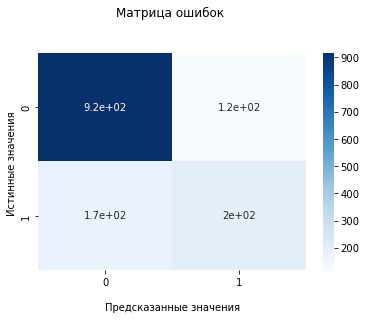

In [ ]:


ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Матрица ошибок \n\n');
ax.set_xlabel('\nПредсказанные значения')
ax.set_ylabel('Истинные значения ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

## Display the visualization of the Confusion Matrix.
plt.show()

### 4.5 Анализ важности основных факторов, влияющих на отток клиента.

Анализ проведем с помощью `get_feature_importance` встроенного метода CatBoost

In [ ]:
np.array(cb.get_feature_importance(prettified=True))

array([['Type', 24.331267024508502],
       ['TotalCharges', 17.93804784512979],
       ['MonthlyCharges', 9.163397138080533],
       ['InternetService', 8.866308303010314],
       ['OnlineSecurity', 6.215038227950251],
       ['TechSupport', 4.784067373769188],
       ['PaymentMethod', 4.670632966149525],
       ['MultipleLines', 4.408194450549868],
       ['OnlineBackup', 4.276251575509214],
       ['StreamingMovies', 3.30220659781131],
       ['delta', 3.135289025069298],
       ['DeviceProtection', 2.3353282594181906],
       ['PaperlessBilling', 2.0565161788723167],
       ['StreamingTV', 1.877112076023055],
       ['Partner', 0.7387662657267047],
       ['SeniorCitizen', 0.716938925818543],
       ['Dependents', 0.6770097329361765],
       ['gender', 0.5076280336671087]], dtype=object)

Самым важным фактором является тип контракта:
 - c месячной оплатой
 - с оплатой за 1 год
 - с оплатой за 2 года

 Далее идут два финансовых признака:
 - c общей суммой, которую заплатил клиент за все время
 - с ежемесячной оплатой.

 На третьем месте тип подключение интернета:
 - DSL
 - FiberOptic

In [ ]:
contarct_left

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50
8,7892-POOKP,2019-04-27,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05
12,0280-XJGEX,2018-11-13,2019-10-01,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30
...,...,...,...,...,...,...,...,...
1883,1699-HPSBG,2018-10-25,2019-11-01,One year,Yes,Electronic check,59.80,727.80
1884,8775-CEBBJ,2019-01-12,2019-11-01,Month-to-month,Yes,Bank transfer (automatic),44.20,403.35
1885,6894-LFHLY,2019-01-16,2019-11-01,Month-to-month,Yes,Electronic check,75.75,75.75
1886,0639-TSIQW,2019-02-11,2019-10-01,Month-to-month,Yes,Credit card (automatic),102.95,6886.25


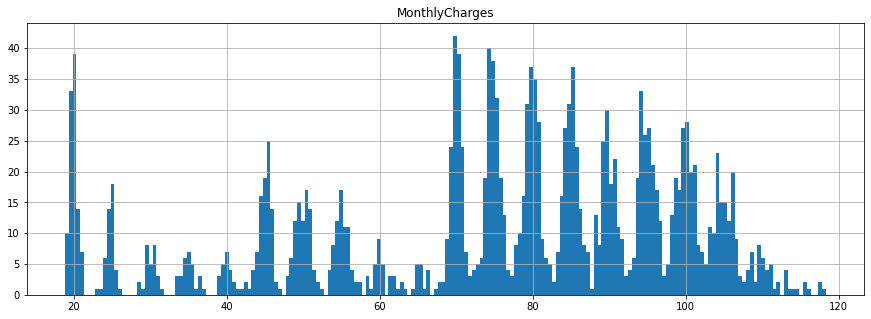

In [ ]:
contarct_left.hist('MonthlyCharges', bins=200, figsize=(15,5))
plt.show()

[0.88550027 0.08881755 0.02568218]


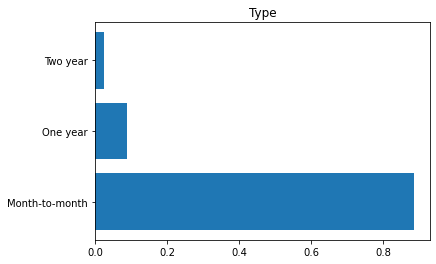

In [ ]:
plot_bar(contarct_left, ['Type'])

## Шаг 5. Сделайте общий вывод по работе

Напишите свои рекомендации оператору связи.

Наибольшая вероятность ухода у абонентов которые(признаки перечислены в порядке убывания важности):
 - имеют помесячные контракты
 - платят в месяц более 60 у.е.
 - используют интернет подлключенный через оптоволокно
 - не имеют супруга/супругу
 - являются пенсионером
 - не имеют детей.

Этим клиентам следует предложить скидки и акции.